In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.20/04


In [2]:
##### setting file path #####

sig_rootpath = "/Storage/Chen-Wang/Lam3000large/Events/run_01/tag_1_delphes_events.root"
sig_file = uproot.open(sig_rootpath)

##### event #####

events = [sig_file["Delphes;1"]["MissingET.MET"].array(),
          sig_file["Delphes;1"]["Electron"].array(),
          sig_file["Delphes;1"]["Muon"].array(),
          sig_file["Delphes;1"]["Jet.TauTag"].array(),
          sig_file["Delphes;1"]["MissingET.Phi"].array(),
          sig_file["Delphes;1"]["Jet.Phi"].array(),
          sig_file["Delphes;1"]["Jet.Eta"].array(),
          sig_file["Delphes;1"]["Jet.BTag"].array(),
          sig_file["Delphes;1"]["Jet.PT"].array(),
          sig_file["Delphes;1"]["Jet.Mass"].array(),
          sig_file["Delphes;1"]["Jet.Constituents"].array()
         ]

features = ["MissingET.MET", "Electron", "Muon", "Jet.TauTag", "MissingET.Phi", "Jet.Phi", "Jet.Eta", "Jet.BTag", "Jet.PT", "Jet.Mass", "Jet.Constituents"]

##### reshape the data #####

events = np.expand_dims(events, axis=-1)
events = events.transpose((1,0,2))
events = np.squeeze(events,axis=(2,))

In [3]:
##### select MET > 150GeV #####

def MET150(events):
    where1 = np.where(events[:,0] > 150)    ### 0 = MET
    return events[where1]

##### select electron veto #####

def electron(events):
    where1 = np.where(events[:,1] == 0)    ### 1 = num of electron
    return events[where1]

##### select muon veto #####

def muon(events):
    where1 = np.where(events[:,2] == 0)    ### 2 = num of muon
    return events[where1]

##### select tauon veto #####

def tauon(events):
    where1 = []
    deg225 = 22.5*np.pi/180
    for i in range(len(events)):
        switch = 1
        METphi = events[i][4]    ### 4 = phi of MET
        if sum(events[i][3]) == 0:    ### 3 = if tau jet
            for j in range(len(events[i][10])):    ### 10 = constituents of jet
                if len(events[i][10][j])<=4:
                    if (2*np.pi-deg225)<abs(events[i][5][j]-METphi)<deg225:    ### 5 = phi of each jet
                        switch = 0
            if switch == 1:
                where1.append(i)
    return events[where1]

##### select d\phi(jet123, MET) < 20 degree #####

def phi(events):
    where1 = []
    deg20 = np.pi/9
    for i in range(len(events)):
        METphi = events[i][4]    ### 4 = phi of MET
        if(len(events[i][5]) == 1):    ### 5 = phi of each jet
            if((2*np.pi-deg20) > abs(events[i][5][0]-METphi) > deg20):
                where1.append(i)
        elif(len(events[i][5]) == 2):
            if((2*np.pi-deg20)>abs(events[i][5][0]-METphi)>deg20 and (2*np.pi-deg20)>abs(events[i][5][1]-METphi)>deg20):
                where1.append(i)
        elif(len(events[i][5]) >= 3):
            if((2*np.pi-deg20)>abs(events[i][5][0]-METphi)>deg20 and (2*np.pi-deg20)>abs(events[i][5][1]-METphi)>deg20 and (2*np.pi-deg20)>abs(events[i][5][2]-METphi)>deg20):
                where1.append(i)
    return events[where1]

##### select MET < 500GeV #####

def MET500(events):
    where1 = np.where(events[:,0] < 500)    ### 0 = MET
    return events[where1]

##### select at least 2 BTag jets #####

def b_jets(events):
    where1 = []
    for i in range(len(events)):
        if sum(events[i][7]) >= 2:    ### 7 = BTag of each jet
            where1.append(i)
    return events[where1]

##### PTh selection #####

def PTh(events):
    where1 = []
    for i in range(len(events)):
        whereb = np.where(events[i][7]==1)[0]    ### 7 = BTag of each jet
        pT1 = events[i][8][whereb[0]]
        pT2 = events[i][8][whereb[1]]
        phi1 = events[i][5][whereb[0]]
        phi2 = events[i][5][whereb[1]]
        pTh = np.sqrt((pT1*np.cos(phi1)+pT2*np.cos(phi2))**2 + (pT1*np.sin(phi1)+pT2*np.sin(phi2))**2)    ### calculate pTh
        if events[i][0] < 350:
            if pTh > 100:
                where1.append(i)
        elif events[i][0] >= 350:
            if pTh > 300:
                where1.append(i)
    return events[where1]

##### mT^bmin > 170 #####

def bmin(events):
    where1 = []
    for i in range(len(events)):
        whereb = np.where(events[i][7]==1)[0]    ### 7 = BTag of each jet
        PT_bmin = events[i][8][whereb[-1]]    ### 8 = PT of each jet
        phi_bmin = events[i][5][whereb[-1]]    ### 5 = phi of each jet
        MET = events[i][0]    ### 0 = MET
        phi_MET = events[i][4]    ### 4 = phi of MET
        mT_bmin = np.sqrt(2*PT_bmin*MET*(1-np.cos(PT_bmin-phi_MET)))
        if mT_bmin > 170:
            where1.append(i)
    return events[where1]

##### mT^bmax > 200 #####

def bmax(events):
    where1 = []
    for i in range(len(events)):
        whereb = np.where(events[i][7]==1)[0]    ### 7 = BTag of each jet
        PT_bmax = events[i][8][whereb[0]]    ### 8 = PT of each jet
        phi_bmax = events[i][5][whereb[0]]    ### 5 = phi of each jet
        MET = events[i][0]    ### 0 = MET
        phi_MET = events[i][4]    ### 4 = phi of MET
        mT_bmax = np.sqrt(2*PT_bmax*MET*(1-np.cos(PT_bmax-phi_MET)))
        if mT_bmax > 200:
            where1.append(i)
    return events[where1]

##### N_jet selection #####

def Njet(events):
    where1 = []
    for i in range(len(events)):
        NBtag = sum(events[i][7])    ### 7 = BTag of each jet
        if NBtag==2:
            if len(events[i][7])<=4:
                where1.append(i)
        elif NBtag>=3:
            if len(events[i][7])<=5:
                where1.append(i)
    return events[where1]

##### 50 GeV < m_bb < 280 GeV #####

def m_bb(events):
    where1 = []
    for i in range(len(events)):
        p4 = [0,0,0,0]    ### four momentum
        m_bb = 0
        whereb = np.where(events[i][7]==1)[0]    ### 7 = BTag of each jet
        for j in range(len(whereb)):
            pT_jet = events[i][8][whereb[j]]    ### 8 = pT of each jet
            phi_jet = events[i][5][whereb[j]]    ### 5 = phi of each jet
            eta_jet = events[i][6][whereb[j]]    ### 6 = eta of each jet
            mass_jet = events[i][9][whereb[j]]    ### 9 = mass of each jet
            p4[1] = p4[1] + pT_jet * np.cos(phi_jet)
            p4[2] = p4[2] + pT_jet * np.sin(phi_jet)
            p4[3] = p4[3] + pT_jet * np.sinh(eta_jet)
            p4[0] = p4[0] + np.sqrt(mass_jet**2 + (pT_jet*np.cos(phi_jet))**2 + (pT_jet*np.sin(phi_jet))**2 + (pT_jet*np.sinh(eta_jet))**2)
        m_bb = np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2)
        if 50<m_bb<280:
            where1.append(i)
    return events[where1]

##### select MET > 500GeV #####

def MET500_merge(events):
    where1 = np.where(events[:,0] > 500)    ### 0 = MET
    return events[where1]

##### 50 GeV < m_bb < 280 GeV #####

def m_bb_merge(events):
    where1 = []
    for i in range(len(events)):
        p4 = [0,0,0,0]    ### four momentum
        m_bb = 0
        whereb = np.where(events[i][7]==1)[0]    ### 7 = BTag of each jet
        for j in range(len(whereb)):
            pT_jet = events[i][8][whereb[j]]    ### 8 = pT of each jet
            phi_jet = events[i][5][whereb[j]]    ### 5 = phi of each jet
            eta_jet = events[i][6][whereb[j]]    ### 6 = eta of each jet
            mass_jet = events[i][9][whereb[j]]    ### 9 = mass of each jet
            p4[1] = p4[1] + pT_jet * np.cos(phi_jet)
            p4[2] = p4[2] + pT_jet * np.sin(phi_jet)
            p4[3] = p4[3] + pT_jet * np.sinh(eta_jet)
            p4[0] = p4[0] + np.sqrt(mass_jet**2 + (pT_jet*np.cos(phi_jet))**2 + (pT_jet*np.sin(phi_jet))**2 + (pT_jet*np.sinh(eta_jet))**2)
        m_bb = np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2)
        if 50<m_bb<280:
            where1.append(i)
    return events[where1]

In [4]:
print("Resloved Region")
print("Total events:\t\t", len(events))
events = MET150(events)
print("MET>150:\t\t", len(events))
events = electron(events)
print("electron veto:\t\t", len(events))
events = muon(events)
print("muon veto:\t\t", len(events))
events = tauon(events)
print("tauon veto:\t\t", len(events), "(extended 𝜏-lepton veto same as baseline 𝜏-lepton veto)")
events = phi(events)
print("Δ𝜙(jet123,MET)>20°:\t", len(events))
merge_events = MET500_merge(events)
events = MET500(events)
print("MET<500:\t\t", len(events))
events = b_jets(events)
print(">=2 bTag small-R jets:\t", len(events))
events = PTh(events)
print("PTh selection:\t\t", len(events))
events = bmin(events)
print("m_T(b,min)>170:\t\t", len(events))
events = bmax(events)
print("m_T(b,max)>200:\t\t", len(events))
events = Njet(events)
print("N_jet selection:\t", len(events))
events = m_bb(events)
print("m_bb mass selection:\t", len(events))

Resloved Region
Total events:		 100000
MET>150:		 41443
electron veto:		 40590
muon veto:		 39554
tauon veto:		 36600 (extended 𝜏-lepton veto same as baseline 𝜏-lepton veto)
Δ𝜙(jet123,MET)>20°:	 33609
MET<500:		 32806
>=2 bTag small-R jets:	 7964
PTh selection:		 6624
m_T(b,min)>170:		 2533
m_T(b,max)>200:		 1562
N_jet selection:	 1132
m_bb mass selection:	 1047


In [5]:
print("Merged region")
print("MET>500:\t\t", len(merge_events))
merge_events = b_jets(merge_events)
print(">=2 bTag small-R jets:\t", len(merge_events))
merge_events = PTh(merge_events)
print("PTh selection:\t\t", len(merge_events))
merge_events = bmin(merge_events)
print("m_T(b,min)>170:\t\t", len(merge_events))
merge_events = bmax(merge_events)
print("m_T(b,max)>200:\t\t", len(merge_events))
merge_events = Njet(merge_events)
print("N_jet selection:\t", len(merge_events))
merge_events = m_bb(merge_events)
print("m_bb mass selection:\t", len(merge_events))

Merged region
MET>500:		 803
>=2 bTag small-R jets:	 177
PTh selection:		 60
m_T(b,min)>170:		 49
m_T(b,max)>200:		 45
N_jet selection:	 26
m_bb mass selection:	 20


In [6]:
for i in range(11):
    print(features[i], ":", events[0][i])

MissingET.MET : [249.61176]
Electron : 0
Muon : 0
Jet.TauTag : [0 0]
MissingET.Phi : [0.2272823]
Jet.Phi : [-2.7174575  2.7171245]
Jet.Eta : [-2.284815  -2.1033962]
Jet.BTag : [1 1]
Jet.PT : [196.27309  83.87248]
Jet.Mass : [17.710835 12.224005]
Jet.Constituents : [[1934, 1553, 1550, 1548, 1546, 1893, 1915, 1895, 1911, 1572, 1898, 1577, 1569, 1589, 1586, 1591, 1593, 1584, 1574, 1582, 1580, 1906], [1936, 1596, 1931, 1646, 1648, 1650, 1913, 1927, 1603, 1635, 1632, 1623, 1625, 1627, 1929, 1609, 1607, 1619, 1616, 1920]]


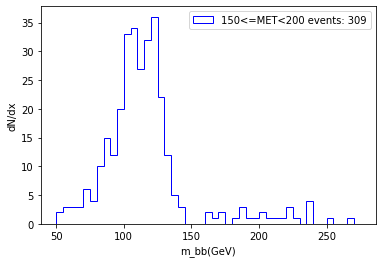

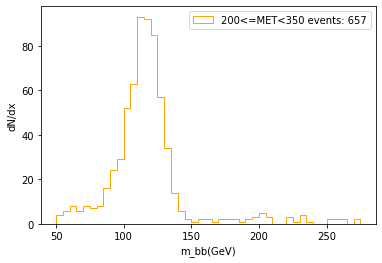

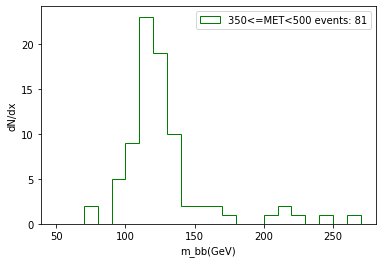

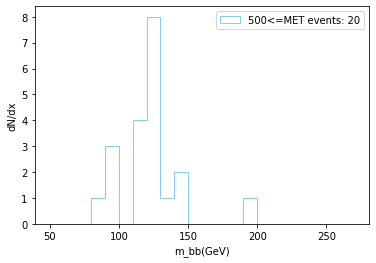

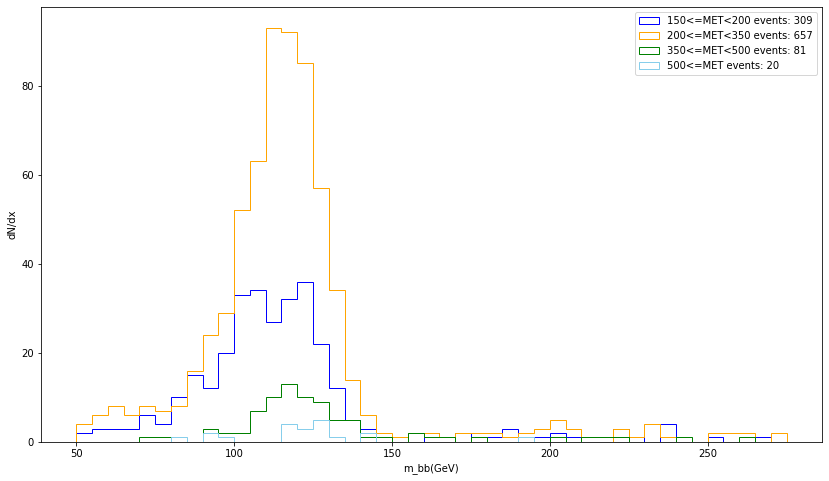

effective cross section: 3.0276125 (fb)


In [7]:
##### define some variables #####

b2m150200 = []  ### mass with 150<=MET<200 with 2 b-tag
b2m200350 = []  ### mass with 200<=MET<350 with 2 b-tag
b2m350500 = []  ### mass with 350<=MET<500 with 2 b-tag
b2m500750 = []  ### mass with 500<=MET<750 with 2 b-tag
b2m750 = []     ### mass with 750<=MET with 2 b-tag

b3m150200 = []  ### mass with 150<=MET<200 with 3 b-tag
b3m200350 = []  ### mass with 200<=MET<350 with 3 b-tag
b3m350500 = []  ### mass with 350<=MET<500 with 3 b-tag
b3m500 = []     ### mass with 500<=MET with 3 b-tag

m150200 = []    ### mass with 150<=MET<200
m200350 = []    ### mass with 200<=MET<350
m350500 = []    ### mass with 350<=MET<500
m500 = []       ### mass with 500<=MET
total = []
bins5 = np.arange(50,280,5)
bins10 = np.arange(50,280,10)

##### plot m_bb #####

for i in range(len(events)):
    p4 = [0,0,0,0]    ### four momentum
    whereb = np.where(events[i][7]==1)[0]    ### 7 = BTag of each jet
    for j in range(len(whereb)):
        pT_jet = events[i][8][whereb[j]]    ### 8 = pT of each jet
        phi_jet = events[i][5][whereb[j]]    ### 5 = phi of each jet
        eta_jet = events[i][6][whereb[j]]    ### 6 = eta of each jet
        mass_jet = events[i][9][whereb[j]]    ### 9 = mass of each jet
        p4[1] = p4[1] + pT_jet * np.cos(phi_jet)
        p4[2] = p4[2] + pT_jet * np.sin(phi_jet)
        p4[3] = p4[3] + pT_jet * np.sinh(eta_jet)
        p4[0] = p4[0] + np.sqrt(mass_jet**2 + (pT_jet*np.cos(phi_jet))**2 + (pT_jet*np.sin(phi_jet))**2 + (pT_jet*np.sinh(eta_jet))**2)
    
    if len(whereb)==2:
        if 150<=events[i][0]<200:        
            b2m150200.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
        elif 200<=events[i][0]<350:
            b2m200350.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
        elif 350<=events[i][0]<500:
            b2m350500.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
    elif len(whereb)>2:
        if 150<=events[i][0]<200:        
            b3m150200.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
        elif 200<=events[i][0]<350:
            b3m200350.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
        elif 350<=events[i][0]<500:
            b3m350500.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
    
    m150200 = b2m150200 + b3m150200
    m200350 = b2m200350 + b3m200350
    m350500 = b2m350500 + b3m350500

'''plt.hist(total, bins=bins5, label='Resolved region: %d' %len(total),color='blue')
#plt.text(190,120, "$\sigma_{signal}$=3.229075(fb)", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("dN/dx")
plt.legend(loc='best')
plt.show()'''
    
plt.hist(m150200, bins=bins5, label='150<=MET<200 events: %d' %len(m150200),histtype='step',color='blue')
#plt.text(150,29, "$\sigma_{signal}$=3.229075(fb)\n5GeV each bin", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("dN/dx")
plt.legend(loc='best')
plt.show()

plt.hist(m200350, bins=bins5, label='200<=MET<350 events: %d' %len(m200350),histtype='step',color='orange')
#plt.text(150,73, "$\sigma_{signal}$=3.229075(fb)\n5GeV each bin", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("dN/dx")
plt.legend(loc='best')
plt.show()

plt.hist(m350500, bins=bins10, label='350<=MET<500 events: %d' %len(m350500),histtype='step',color='green')
#plt.text(150,18, "$\sigma_{signal}$=3.229075(fb)\n10GeV each bin", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("dN/dx")
plt.legend(loc='best')
plt.show()

for i in range(len(merge_events)):
    p4 = [0,0,0,0]    ### four momentum
    whereb = np.where(merge_events[i][7]==1)[0]    ### 7 = BTag of each jet
    for j in range(len(whereb)):
        pT_jet = merge_events[i][8][whereb[j]]    ### 8 = pT of each jet
        phi_jet = merge_events[i][5][whereb[j]]    ### 5 = phi of each jet
        eta_jet = merge_events[i][6][whereb[j]]    ### 6 = eta of each jet
        mass_jet = merge_events[i][9][whereb[j]]    ### 9 = mass of each jet
        p4[1] = p4[1] + pT_jet * np.cos(phi_jet)
        p4[2] = p4[2] + pT_jet * np.sin(phi_jet)
        p4[3] = p4[3] + pT_jet * np.sinh(eta_jet)
        p4[0] = p4[0] + np.sqrt(mass_jet**2 + (pT_jet*np.cos(phi_jet))**2 + (pT_jet*np.sin(phi_jet))**2 + (pT_jet*np.sinh(eta_jet))**2)   
    if len(whereb)==2:
        if merge_events[i][0]<750:
            b2m500750.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
        else:
            b2m750.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
            total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
    elif len(whereb)>2:
        b3m500.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
        total.append(np.sqrt(p4[0]**2 - p4[1]**2 - p4[2]**2 - p4[3]**2))
    m500 = b2m500750 + b2m750 + b3m500
    
plt.hist(m500, bins=bins10, label='500<=MET events: %d' %len(m500),histtype='step',color='skyblue')
plt.xlabel("m_bb(GeV)")
plt.ylabel("dN/dx")
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14,8))
plt.hist(m150200, bins=bins5, label='150<=MET<200 events: %d' %len(m150200),histtype='step',color='blue')
plt.hist(m200350, bins=bins5, label='200<=MET<350 events: %d' %len(m200350),histtype='step',color='orange')
plt.hist(m350500, bins=bins5, label='350<=MET<500 events: %d' %len(m350500),histtype='step',color='green')
plt.hist(m500, bins=bins5, label='500<=MET events: %d' %len(m500),histtype='step',color='skyblue')
#plt.text(190,60, "$\sigma_{signal}$=3.229075(fb)\n", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("dN/dx")
plt.legend(loc='best')
plt.show()

effectice_crosssection = len(total)*2.8375e-6
print("effective cross section:", effectice_crosssection*1000,"(fb)")

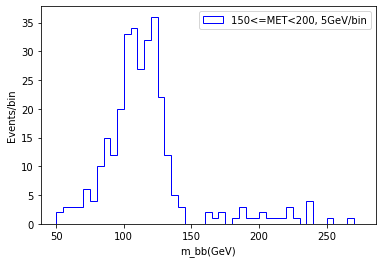

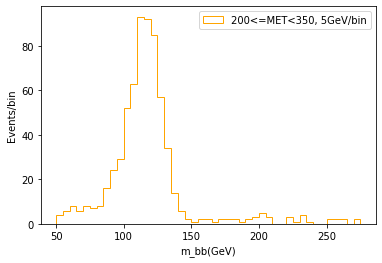

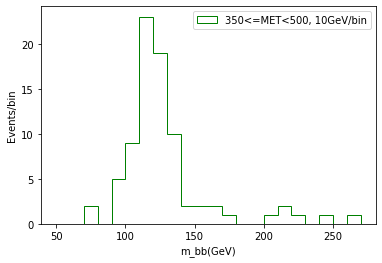

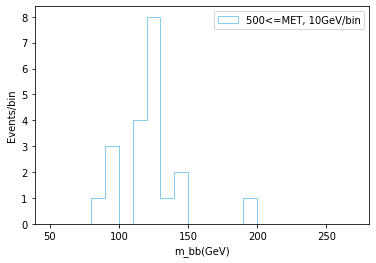

In [8]:
##### plot without number of events #####

plt.hist(m150200, bins=bins5, label='150<=MET<200, 5GeV/bin',histtype='step',color='blue')
#plt.text(150,29, "$\sigma_{signal}$=3.229075(fb)\n5GeV each bin", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("Events/bin")
plt.legend(loc='best')
plt.show()

plt.hist(m200350, bins=bins5, label='200<=MET<350, 5GeV/bin',histtype='step',color='orange')
#plt.text(150,73, "$\sigma_{signal}$=3.229075(fb)\n5GeV each bin", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("Events/bin")
plt.legend(loc='best')
plt.show()

plt.hist(m350500, bins=bins10, label='350<=MET<500, 10GeV/bin',histtype='step',color='green')
#plt.text(150,18, "$\sigma_{signal}$=3.229075(fb)\n10GeV each bin", fontsize=12)
plt.xlabel("m_bb(GeV)")
plt.ylabel("Events/bin")
plt.legend(loc='best')
plt.show()

plt.hist(m500, bins=bins10, label='500<=MET, 10GeV/bin',histtype='step',color='skyblue')
plt.xlabel("m_bb(GeV)")
plt.ylabel("Events/bin")
plt.legend(loc='best')
plt.show()

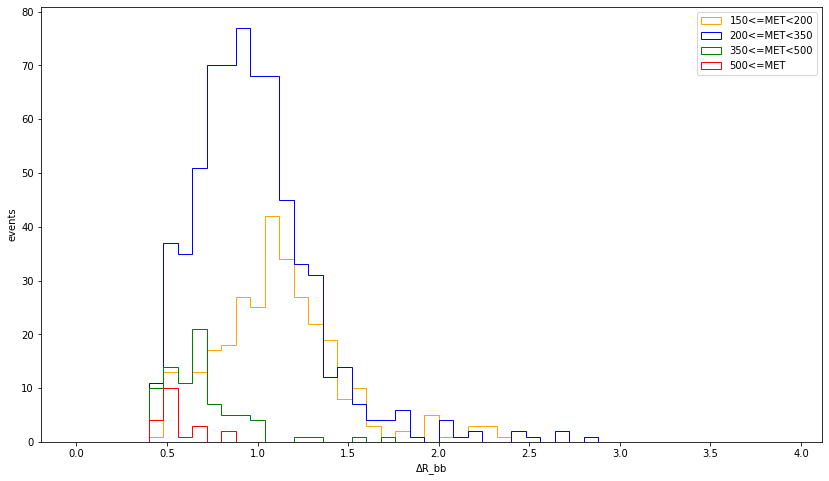

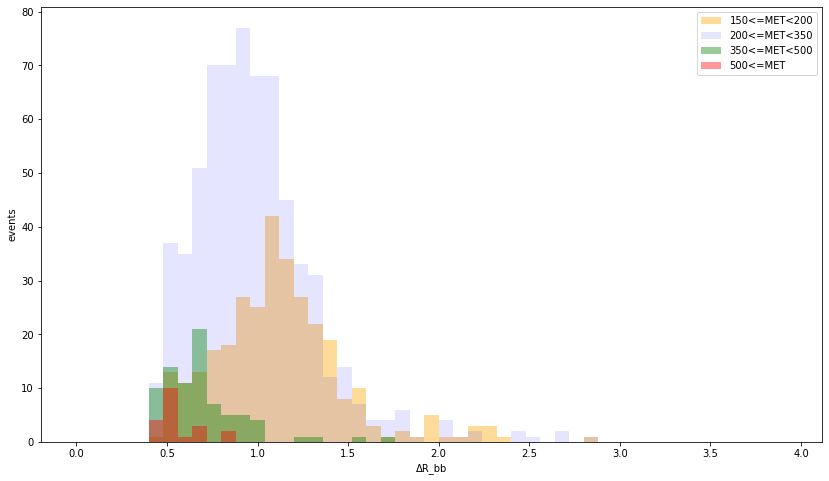

In [9]:
################################################
##    find the relation between MET and ΔR    ##
################################################

##### define some variables #####

DR150200 = []    ### ΔR with 150<=MET<200
DR200350 = []    ### ΔR with 200<=MET<350
DR350500 = []    ### ΔR with 350<=MET<500
DR500 = []       ### ΔR with 500<=MET
binsDR = np.arange(0.0,4,0.08)

##### calculate ΔR #####

for i in range(len(events)):
    whereb = np.where(events[i][7]==1)[0][0:2]    ### 7 = BTag of each jet and only take 2 largest pT jets
    phi = events[i][5][whereb]    ### 5 = Phi of each jet
    eta = events[i][6][whereb]    ### 6 = Eta of each jet
    Dphi = abs(phi[0] - phi[1])
    if Dphi >= np.pi:             ### Dphi may exceed pi
        Dphi = 2*np.pi - Dphi
    Deta = abs(eta[0] - eta[1])
    DR = np.sqrt(Dphi**2 + Deta**2)
    MET = events[i][0]
    
    if 150<=MET<200:
        DR150200.append(DR)
    elif 200<=MET<350:
        DR200350.append(DR)
    elif 200<=MET<350:
        DR200350.append(DR)
    elif 350<=MET<500:
        DR350500.append(DR)
        
for i in range(len(merge_events)):
    whereb = np.where(merge_events[i][7]==1)[0][0:2]    ### 7 = BTag of each jet and only take 2 largest pT jets
    phi = merge_events[i][5][whereb]    ### 5 = Phi of each jet
    eta = merge_events[i][6][whereb]    ### 6 = Eta of each jet
    Dphi = abs(phi[0] - phi[1])
    if Dphi >= np.pi:             ### Dphi may exceed pi
        Dphi = 2*np.pi - Dphi
    Deta = abs(eta[0] - eta[1])
    DR = np.sqrt(Dphi**2 + Deta**2)
    MET = merge_events[i][0]
    DR500.append(DR)
        
##### plot out #####

plt.figure(figsize=(14,8))
plt.hist(DR150200, bins=binsDR, histtype='step', label='150<=MET<200', color='orange')
plt.hist(DR200350, bins=binsDR, histtype='step', label='200<=MET<350', color='blue')
plt.hist(DR350500, bins=binsDR, histtype='step', label='350<=MET<500', color='green')
plt.hist(DR500, bins=binsDR, histtype='step', label='500<=MET', color='red')
plt.xlabel("ΔR_bb")
plt.ylabel("events")
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14,8))
plt.hist(DR150200, bins=binsDR, alpha=0.4, label='150<=MET<200', color='orange')
plt.hist(DR200350, bins=binsDR, alpha=0.1, label='200<=MET<350', color='blue')
plt.hist(DR350500, bins=binsDR, alpha=0.4, label='350<=MET<500', color='green')
plt.hist(DR500, bins=binsDR, alpha=0.4, label='500<=MET', color='red')
plt.xlabel("ΔR_bb")
plt.ylabel("events")
plt.legend(loc='best')
plt.show()

In [10]:
weight = 2.8375e-6    ### unit:pb
print("Btag = 2 region:")
print("150<=MET<200:", len(b2m150200)*weight*1000, "(fb)")
print("200<=MET<350:", len(b2m200350)*weight*1000, "(fb)")
print("350<=MET<500:", len(b2m350500)*weight*1000, "(fb)")
print("500<=MET<750:", len(b2m500750)*weight*1000, "(fb)")
print("750<=MET:", len(b2m750)*weight*1000, "(fb)")

print("\nBtag >= 3 region:")
print("150<=MET<200:", len(b3m150200)*weight*1000, "(fb)")
print("200<=MET<350:", len(b3m200350)*weight*1000, "(fb)")
print("350<=MET<500:", len(b3m350500)*weight*1000, "(fb)")
print("500<=MET:", len(b3m500)*weight*1000, "(fb)")

print("\nselection acception rate:", len(total)/100000)

Btag = 2 region:
150<=MET<200: 0.834225 (fb)
200<=MET<350: 1.75925 (fb)
350<=MET<500: 0.2184875 (fb)
500<=MET<750: 0.053912499999999995 (fb)
750<=MET: 0.0028374999999999997 (fb)

Btag >= 3 region:
150<=MET<200: 0.042562499999999996 (fb)
200<=MET<350: 0.1049875 (fb)
350<=MET<500: 0.011349999999999999 (fb)
500<=MET: 0.0 (fb)

selection acception rate: 0.01067


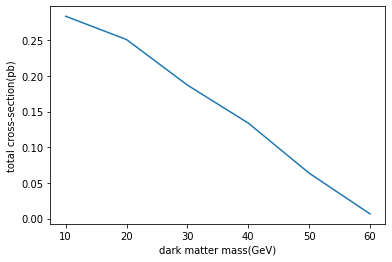

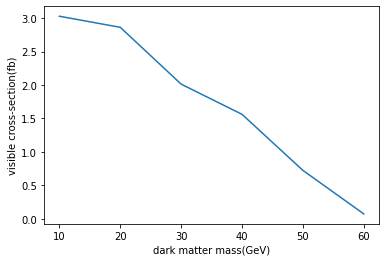

In [16]:
DMmass = [10,20,30,40,50,60]
totalXsection = [0.28375, 0.25105, 0.18718, 0.13388, 0.063672, 0.0064903]
visXsection = [3.0276125, 2.86197, 2.012185, 1.5610408, 0.7226772, 0.071847621]

plt.plot(DMmass, totalXsection)
plt.xlabel("dark matter mass(GeV)")
plt.ylabel("total cross-section(pb)")
plt.show()

plt.plot(DMmass, visXsection)
plt.xlabel("dark matter mass(GeV)")
plt.ylabel("visible cross-section(fb)")
plt.show()